![](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)

# 1. Introduction

In this Kernel I will develop my take on the classic competition of Digit Recognizer using the nice Python module called [Catalyst](https://github.com/catalyst-team/catalyst). It's good because you can write modular and reproducible code to future experiments.<br>
Let's start installing catalyst module.<br>
Now import all required modules.

In [1]:
# Standard Modules
import numpy as np
import pandas as pd
# Graphic Plots
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('darkgrid')
# Extra Tools
import os
import warnings
import math
import random
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
# PyTorch and Catalyst
import collections
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from catalyst.dl import utils
from catalyst.dl.runner import SupervisedRunner
from catalyst.dl.callbacks import AccuracyCallback
from catalyst.utils import set_global_seed, prepare_cudnn
# For better plot visualization
%config InlineBackend.figure_format = 'retina'
# Enviroment PATH
PATH = '../input/digit-recognizer/'
print(os.listdir(PATH))

['train.csv', 'test.csv', 'sample_submission.csv']


And set the enviroment settings for reprodutibility.

In [2]:
SEED = 42
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
set_global_seed(SEED)                       
prepare_cudnn(deterministic=True)           

Let's use [NVIDIA Apex](https://github.com/NVIDIA/apex) to work with [Mixed Precision Training](https://docs.nvidia.com/deeplearning/sdk/mixed-precision-training/index.html), also called Automatic Mixed Precision (AMP).
Set it to use FP16 and install Apex.

In [3]:
FP16_PARAMS = None

In [4]:
%%writefile setup.sh
git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
rm -rf ./apex

Writing setup.sh


In [5]:
%%capture
!sh setup.sh
FP16_PARAMS = dict(opt_level="O1") 

# 2. Load Datasets and Explore the Images

Load the datasets in Pandas Dataframes and take a look on the Train Set to check the dataset format.

In [6]:
train_raw = pd.read_csv(PATH+'train.csv')
test_raw = pd.read_csv(PATH+'test.csv')
submission = pd.read_csv(PATH+'sample_submission.csv')
train_raw.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Although this is an image competition, is provided tabular data, where each feature column represents an image pixel. <br>
Let's see how many samples (images) it have.

In [7]:
print(f'Train Samples: {train_raw.shape[0]}')
print(f'Test Samples: {test_raw.shape[0]}')

Train Samples: 42000
Test Samples: 28000


Check the label distribution to find any disbalance.

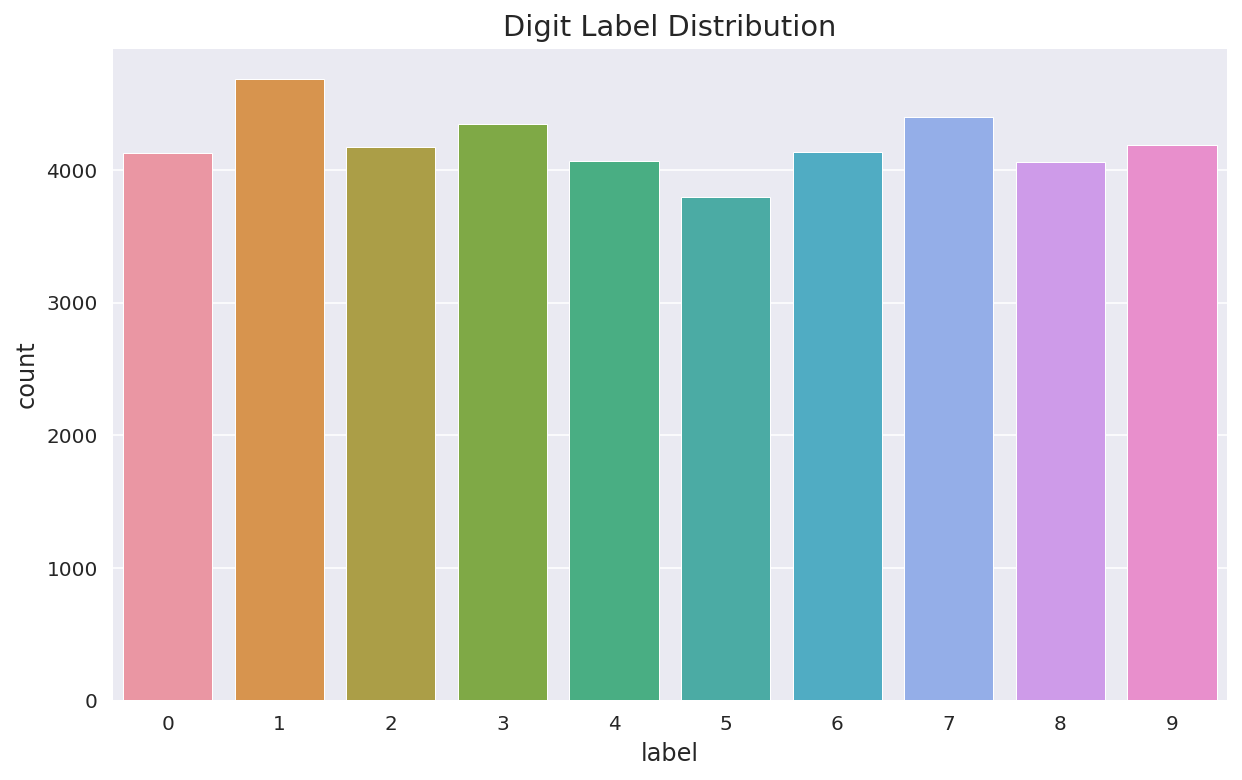

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=train_raw)
plt.title('Digit Label Distribution');

Time to see how the samples look like images. For this, they will reshaped for images with 28x28 pixels, because the product of this results in 784, the number of columns/pixels in the dataset (except label column). 

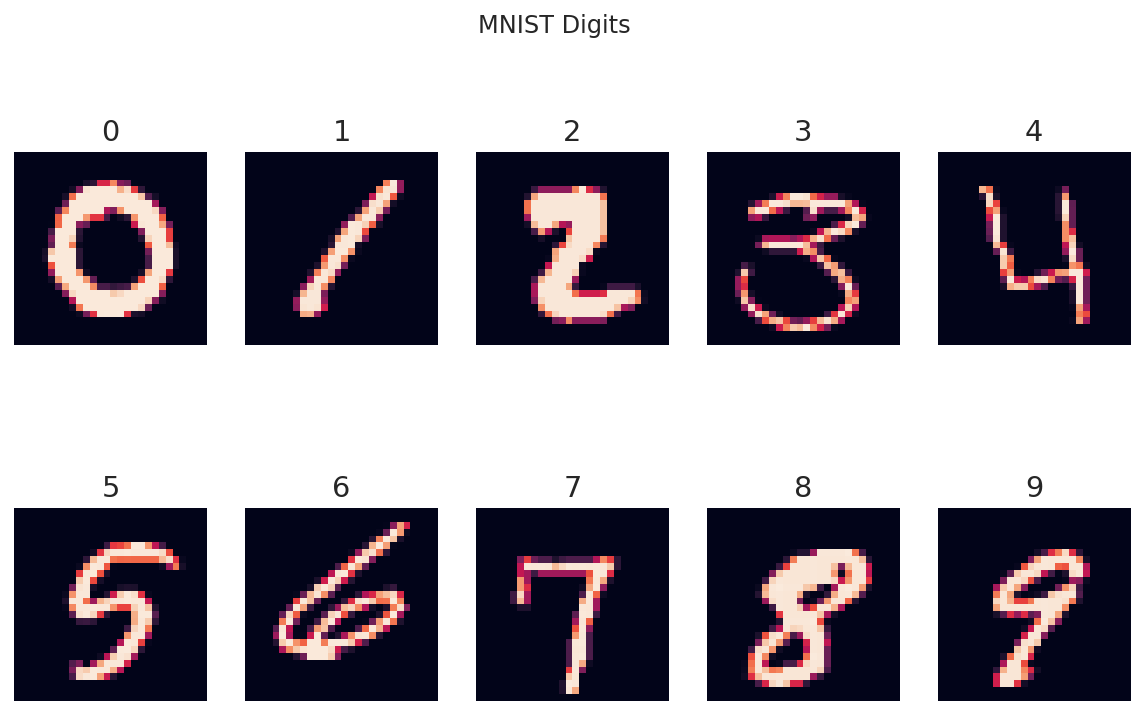

In [9]:
label_index = []
for i in range(10):
  label_index.append(train_raw.index[train_raw['label'] == i][0])

fig = plt.figure(figsize=(10,6))

idx = 1

for i in label_index:
  plt.subplot(2, 5, idx)
  plt.imshow(train_raw.iloc[i,1:].values.reshape(28, 28))
  plt.axis('off')
  plt.suptitle('MNIST Digits')
  plt.title(str(train_raw['label'].loc[i]))
  idx = idx+1

plt.show()

# 3. Data Preparation for Catalyst

We start splitting the train dataframe in train and validations sets.

In [10]:
x_train, x_val, y_train, y_val = train_test_split(train_raw.iloc[:, 1:], 
                                                  train_raw['label'], 
                                                  test_size=0.3, 
                                                  random_state=42)

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

As we have a Pandas Dataframe with pixel values, it's needed to transform in tensors, they will be input of the Network. <br>
The pixels are normalized with the transform.
Let's just write how the transform will work.

In [11]:
data_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

For the Catalyst, we have to write a class called dataset to prepare the data for the network. <br>
On the Dataset class is defined the input, label and any process, like tranformations, in the data.

In [12]:
class MnistDataset(Dataset):
# Get input, labels and transforms
  def __init__(self, images, labels=None, transform=None):
    self.x = images
    self.y = labels
    self.transform = transform
# Get data length
  def __len__(self):
    return len(self.x)
# Get data index
  def __getitem__(self, i):
    data = np.array(self.x.iloc[i, :], dtype='uint8').reshape([28, 28, 1])

    if self.transform is not None:
      data = self.transform(data)
    if self.y is not None:
      target = self.y.iloc[i]
      return data, target
    else:
      return data

Here, we define the parameters of the experiment, like Batch Size, Iterations, etc.

In [13]:
num_class = 10
batch_size = 32
num_workers = 4
n_iters = 5000
n_epochs = int(n_iters/(len(x_train)/batch_size))

It's a personal choice, I create fake labels for the test set for avoid any error on Catalyst.

In [14]:
fake_labels = np.zeros(test_raw.shape[0])
fake_labels = pd.Series(fake_labels)
fake_labels = fake_labels.astype(int)

Time to convert the data on Catalyst Dataset.

In [15]:
train = MnistDataset(x_train, y_train, transform=data_transform)
val = MnistDataset(x_val, y_val, transform=data_transform)
test = MnistDataset(test_raw, fake_labels, transform=data_transform)

And get these datasets and put they on Loaders. <br>
Loaders in Catalyst provide parameters like batch size together the data.

In [16]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Put the train and validation loaders in dictionares to feed the network.

In [17]:
loaders = collections.OrderedDict()
loaders["train"] = train_loader
loaders["valid"] = val_loader

We have the advantage of use GPU, let's check for any available and save it for use on Catalyst.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 4. Model

Time to build the model! This is a nice part on Catalyst, it's modular, is easy to change any part like the network. <br>
If you see on this competition, you will find a lot of interesting model networks, I think that the model that is provided [here](https://www.kaggle.com/juiyangchang/cnn-with-pytorch-0-995-accuracy) is good enough.

In [19]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x    

Now, we assemble each component created before and run the expirement on Catalyst. <br>
Let's start training the network.

In [20]:
%%time
# Experiment
logdir = './logs/mnist'

model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

runner = SupervisedRunner()

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=[
        AccuracyCallback(num_classes=num_class),
    ],
    logdir=logdir,
    num_epochs=n_epochs,
    fp16=FP16_PARAMS,
    verbose=False
)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning:

nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning:

nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning:

nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
[2020-04-18 14:15:45,662] 
1/5 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/5 * Epoch 1 (train): _timer/_fps=1373.2228 | _timer/batch_time=0.0257 | _

It's possible to check the saved models on the `logdir` directory defined early.

In [21]:
!ls ./logs/mnist/checkpoints

_metrics.json  best_full.pth  last_full.pth  train.4_full.pth
best.pth       last.pth       train.4.pth


# 5. Predictions

Ok, let's run our prediction. Remember the fake labels? I used here to don't get errors on predict.

In [22]:
runner_out = runner.predict_loader(model=model, loader=test_loader, resume=f"{logdir}/checkpoints/best.pth")

Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
=> loading checkpoint ./logs/mnist/checkpoints/best.pth
loaded checkpoint ./logs/mnist/checkpoints/best.pth (global epoch 4, epoch 4, stage train)


And save the results on submission file for the competition.

In [23]:
_,results = torch.topk(torch.from_numpy(runner_out),1)
submission.columns 
submission_final = pd.DataFrame({'ImageId':submission.ImageId,'Label':np.squeeze(results.numpy())},columns=['ImageId','Label'])
submission_final.to_csv('submission_final.csv',index=False)
print("Predictions made and Submission file saved!")

Predictions made and Submission file saved!


# 6. Conclusion

Catalyst is awesome module to work with Deep Learning, it is based on the great PyTorch, but without use any complicated code lines and is friendly user. <br>
Another advantage, due the PyTorch, is that easy to change and classification and segmentation tasks. Catalyst is really worth to give a try!
About the Mixed Precision Training, it is so good, because the task gain more power to deal with big datasets, like images.